In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import certifi
import ssl
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# fix SSL certificate issues by specifying certificate path
os.environ['SSL_CERT_FILE'] = certifi.where()

In [3]:
# set random seed for reproducibility
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 101
setup_seed(SEED)

In [4]:
# check for gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [5]:
# setup data directories with confirmed path
base_dir = "../DeepLearningProject/datasets"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

In [6]:
# define the dataset class
class KneeOADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # collect all images and labels
        for label in range(5):  # Labels: 0 to 4 (severity levels)
            label_dir = os.path.join(root_dir, str(label))
            if os.path.exists(label_dir):
                for img_name in os.listdir(label_dir):
                    self.image_paths.append(os.path.join(label_dir, img_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [7]:
# data transforms with augmentation for training
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [8]:
# create datasets
train_dataset = KneeOADataset(train_dir, transform=data_transforms['train'])
val_dataset = KneeOADataset(val_dir, transform=data_transforms['val'])
test_dataset = KneeOADataset(test_dir, transform=data_transforms['test'])

In [9]:
# check dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 5778
Validation set size: 826
Test set size: 1656


In [10]:
# create data loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

In [11]:
# create vgg11 model with transfer learning
def create_vgg11_model():
    # load pre-trained VGG11 with batch normalization
    model = models.vgg11_bn(weights=models.VGG11_BN_Weights.DEFAULT)
    
    # freeze early convolutional layers for transfer learning
    for param in model.features[:6].parameters():  # freeze first few layers
        param.requires_grad = False
    
    # modify the classifier for our task (5 classes for OA grades)
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, 5)  # 5 classes (0-4 severity)
    
    return model.to(device)

In [12]:
# training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    start_time = time.time()
    
    # initialize variables to track best model
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    # track training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # each epoch has training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            # iterate over batches
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero gradients
                optimizer.zero_grad()
                
                # forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    # backward pass + optimize only in training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # calculate epoch statistics
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            # store in history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()
        
        # update learning rate
        if scheduler is not None:
            scheduler.step()
        
        print()
    
    # training completed
    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # load the best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [13]:
# test model function
def test_model(model, test_loader):
    model.eval()
    running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            running_corrects += torch.sum(preds == labels.data)
    
    acc = running_corrects.double() / len(test_loader.dataset)
    print(f'Test Accuracy: {acc:.4f}')
    return acc.item()

In [14]:
# plot training history
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    
    # plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [15]:
# initialize and train the VGG11 model
vgg11_model = create_vgg11_model()

# setup loss function, optimizer and scheduler
criterion = nn.CrossEntropyLoss()

# only optimize parameters that require gradients
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vgg11_model.parameters()), lr=0.001)

# learning rate scheduler to reduce LR after a few epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [16]:
# train the model
print("\nTraining VGG11 for Knee Osteoarthritis Classification...")
vgg11_model, vgg11_history = train_model(
    vgg11_model, 
    criterion, 
    optimizer, 
    scheduler, 
    num_epochs=10
)


Training VGG11 for Knee Osteoarthritis Classification...
Epoch 1/10
----------
train Loss: 1.4328 Acc: 0.3866
val Loss: 1.3764 Acc: 0.4007

Epoch 2/10
----------
train Loss: 1.2222 Acc: 0.4865
val Loss: 1.0433 Acc: 0.5775

Epoch 3/10
----------
train Loss: 1.0121 Acc: 0.5807
val Loss: 1.1010 Acc: 0.5254

Epoch 4/10
----------
train Loss: 0.8557 Acc: 0.6430
val Loss: 0.9115 Acc: 0.6247

Epoch 5/10
----------
train Loss: 0.7944 Acc: 0.6677
val Loss: 0.8884 Acc: 0.6320

Epoch 6/10
----------
train Loss: 0.7574 Acc: 0.6828
val Loss: 0.8778 Acc: 0.6223

Epoch 7/10
----------
train Loss: 0.7257 Acc: 0.6978
val Loss: 0.8760 Acc: 0.6404

Epoch 8/10
----------
train Loss: 0.7236 Acc: 0.6982
val Loss: 0.8747 Acc: 0.6404

Epoch 9/10
----------
train Loss: 0.7156 Acc: 0.6945
val Loss: 0.8759 Acc: 0.6416

Epoch 10/10
----------
train Loss: 0.7066 Acc: 0.7020
val Loss: 0.8770 Acc: 0.6380

Training complete in 106m 9s
Best val Acc: 0.6416


In [17]:
# evaluate on test set
print("\nEvaluating on test set...")
vgg11_acc = test_model(vgg11_model, dataloaders['test'])


Evaluating on test set...
Test Accuracy: 0.6751


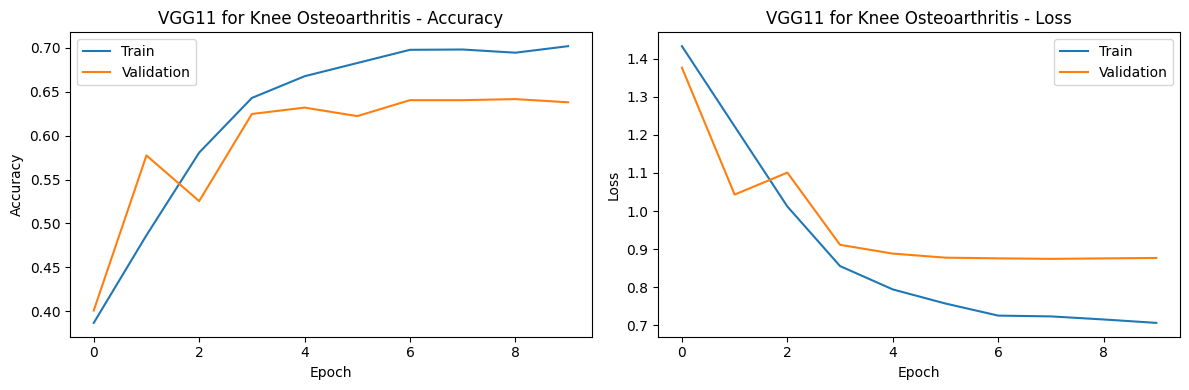

In [18]:
# plot results
plot_history(vgg11_history, "VGG11 for Knee Osteoarthritis")

In [19]:
# save the trained model
torch.save(vgg11_model.state_dict(), "vgg11_knee_oa.pth")
print("\nModel saved as 'vgg11_knee_oa.pth'")


Model saved as 'vgg11_knee_oa.pth'


In [20]:
# Show final results
print(f"\nFinal test accuracy: {vgg11_acc:.4f}")


Final test accuracy: 0.6751
